# Loading data

In [1]:
import os 
os.getcwd()

'c:\\Users\\Alex\\Documents\\repos\\Predicting-ATP-Tennis-Match-Outcomes\\Python'

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
X_train = pd.read_csv("Temp data/X_train.csv", sep=",")
X_test = pd.read_csv("Temp data/X_test.csv", sep=",")
y_train = pd.read_csv("Temp data/y_train.csv", sep=",")
y_test = pd.read_csv("Temp data/y_test.csv", sep=",")

## Preprocessing

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.impute import SimpleImputer, KNNImputer

num_var = ['rank_diff','age_diff','height_diff','Rolling_WLR_diff','Rolling_WLR_5_diff','Rolling_SVP_diff',
           'Rolling_SVP_5_diff','Rolling_SSWP_diff','Rolling_SSWP_5_diff','Rolling_BPS_diff','Rolling_BPS_5_diff']

cat_var = ["draw_size", "surface", "tourney_level"]

numeric_pipe = Pipeline([
    ('imputer',SimpleImputer(strategy='mean')),
    ("diff_standardize", StandardScaler())

])

cat_pipe = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ("onehot_cat", OneHotEncoder(sparse_output=False, categories='auto', drop='first', handle_unknown='ignore'))

])


preprocessor1 = ColumnTransformer([
 ('numeric', numeric_pipe, num_var),
 ('categorical', cat_pipe, cat_var)   
], remainder="drop")



# Gradient-boosting model

In [4]:

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


gbm = Pipeline(
    [
        ("preprocessor",preprocessor1),
        ("regressor", HistGradientBoostingClassifier())
    ]
)
gbm.fit(X_train,y_train)
gbm_pred = gbm.predict_proba(X_test)[:,1]



## Confusion-matrix and AUC

The response variable is, by construction, perfectly balanced and therefore it seems sufficient to consider the Accuracy as the main validation metric. 

[[22683 11082]
 [10918 22910]]


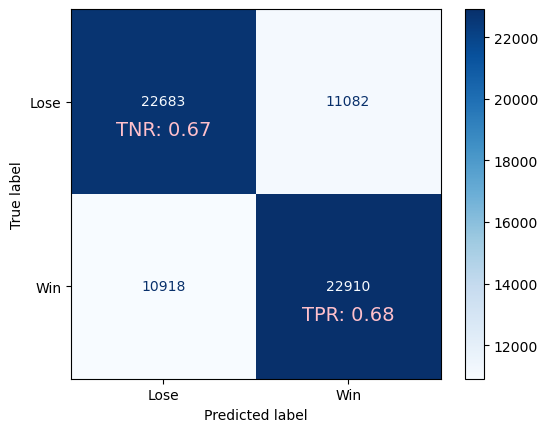

In [5]:
import matplotlib.pyplot as plt
gbm_pred_label = [1 if val >= 0.5 else 0 for val in gbm_pred]
gbm_confusion = confusion_matrix(y_test,gbm_pred_label)
print(gbm_confusion)
# Calculate true positive rate (sensitivity)
TPR = gbm_confusion[1, 1] / (gbm_confusion[1, 1] + gbm_confusion[1, 0])
TNR = gbm_confusion[0, 0] / (gbm_confusion[0, 0] + gbm_confusion[0, 1])
Accuracy = (gbm_confusion[1, 1] +gbm_confusion[0, 0]) /(gbm_confusion[0, 0] + gbm_confusion[1, 0]+gbm_confusion[0, 1] + gbm_confusion[1, 1])
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=gbm_confusion, display_labels=['Lose', 'Win'])
disp.plot(cmap='Blues', values_format='d')  # Adjust the colormap and format as needed

# Add text for true positive rate
plt.text(1, 1.1, f'TPR: {TPR:.2f}', color='pink', fontsize=14, va='top', ha='center')
plt.text(0, 0.1, f'TNR: {TNR:.2f}', color='pink', fontsize=14, va='top', ha='center')

# Show the plot
plt.show()

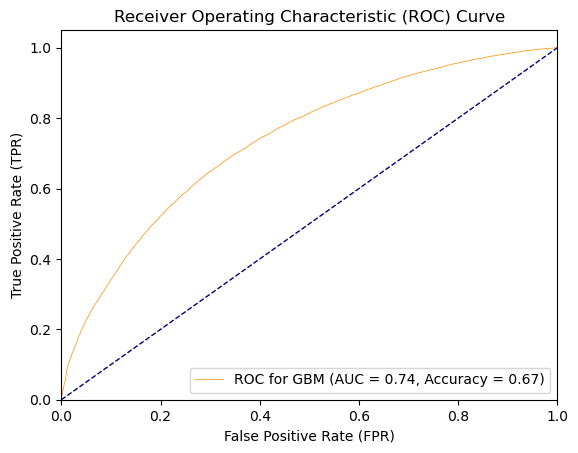

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import mean_squared_error
fpr1, tpr1, thresholds = roc_curve(y_test, gbm_pred)
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, color='darkorange', lw=.5, label=f'ROC for GBM (AUC = {roc_auc1:.2f}, Accuracy = {Accuracy:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The Accuracy metric measures the overall accuracy of our model, i.e. the number of correct classifications out of the total number of classifications, and can be extracted from the confusion matrix. 
\begin{equation*}
\text{Accuracy} = \dfrac{TP+TN}{P+N}
\end{equation*}.

### Partial dependence plots (PDP'S)

In [7]:
%%script false
fig, ax = plt.subplots(figsize=(10, 10))

from sklearn.inspection import PartialDependenceDisplay 
sample = X_train.sample(20000)
display = PartialDependenceDisplay.from_estimator(gbm, sample, features = num_var, ax = ax)
fig.tight_layout()


Couldn't find program: 'false'


Issue with PDPS for some variables. We can define a partial dependence function from scrath and use this implementation to create PDP's. 

In [8]:
import numpy as np
import random
from tqdm import tqdm
def partial(pipe,var,frac=1, n = 40):
    X = X_train.copy()
    X = X.sample(frac=frac)
    y = y_train.loc[X.index]
    pipe.fit(X_train,y_train)
    predictions = []
    values = X_train[var].drop_duplicates()
    values = np.sort(values)
    l = round(np.nanpercentile(values,10),0)
    u = round(np.nanpercentile(values,90),0)
    if n > len(values):
        n = len(values)
    values_sample = random.sample(list(values),n)
    values_sample = np.sort(values_sample)
    for val in tqdm(values_sample): 
          data = X_train.copy()
          data[var] = val 
          prediction = np.mean(pipe.predict(data))
          predictions.append(prediction)
    
    return values_sample, predictions, l, u, var



100%|██████████| 100/100 [02:14<00:00,  1.34s/it]


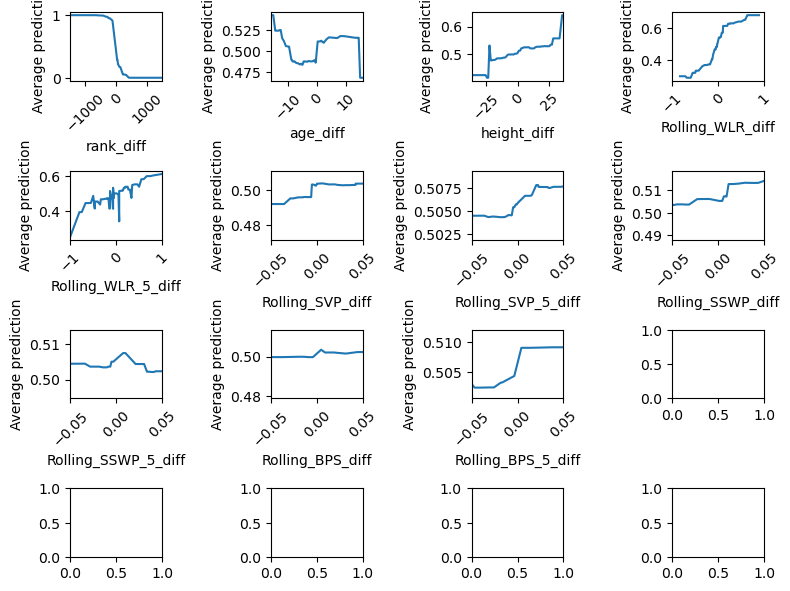

In [9]:
pdps = [partial(gbm,v, frac = 0.2, n = 100) for v in num_var]

num_rows = np.ceil(np.sqrt(len(pdps)))
num_rows = int(num_rows)
num_cols = np.ceil(np.sqrt(len(pdps)))
num_cols = int(num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 6))
axs = axs.flatten()  # Flatten the array of axes to iterate over it

for ax, (values_sample, predictions, l, u, var) in zip(axs, pdps):
    ax.plot(values_sample, predictions, label='Partial Dependence')
    ax.set_xlim(l, u)
    ax.set_ylabel('Average prediction')
    ax.set_xlabel(var)
    plt.setp(ax.get_xticklabels(), rotation=45)  # Rotate the x-axis labels

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()
    



## Variable importance from Random Forest classifier

In [10]:

%%capture 
from sklearn.ensemble import RandomForestClassifier
X_train_subset = X_train.sample(n = 5000, random_state = 1)
y_train_subset = y_train.loc[X_train_subset.index]


forest = Pipeline(
    [
        ("preprocessor",preprocessor1),
        ("regressor", RandomForestClassifier())
    ]
)

forest.fit(X_train,y_train)


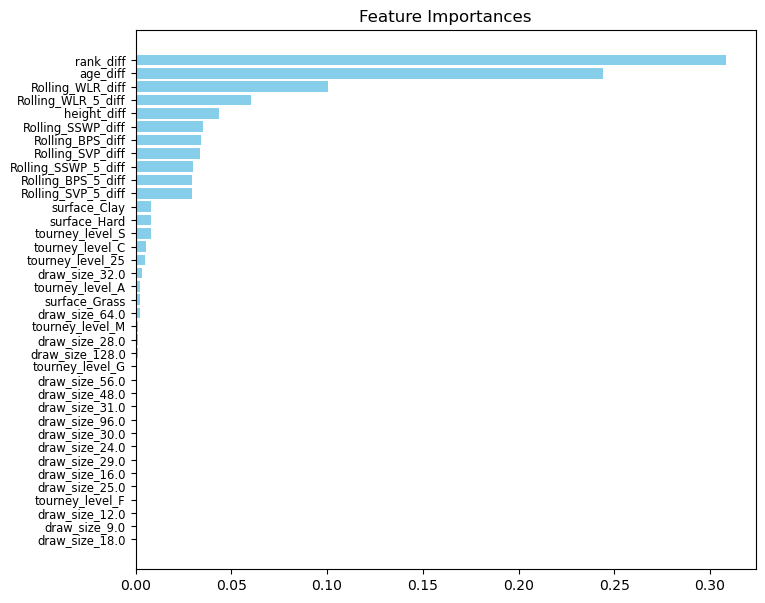

In [53]:

#%%script false
import numpy as np
import matplotlib.pyplot as plt
importances = forest.named_steps["regressor"].feature_importances_
indices = np.argsort(importances)[::1]
features = forest.named_steps["preprocessor"].get_feature_names_out()
features = [name.split('__')[-1] for name in features]
features_int = range(len(features)) 
plt.figure(figsize=(8,7))  
plt.barh(features_int, importances[indices], align="center", color = 'skyblue')  # Create horizontal bar plot
plt.yticks(features_int, np.array(features)[indices], fontsize = 'small')  # Set y-axis tick labels
plt.title("Feature Importances")
plt.show()


The difference in ranking ,rather obviously, has a high impact on the outcome. Other variables of importance include:
- The difference in age
- The difference in rolling win-loss ratio
- The difference in height
- The difference in rolling second serve win percentage
- The difference in rolling break points saved percentage
- The difference in rolling first serve percentage


# XGBoost

In [12]:
import xgboost as xgb
xgb_clf = Pipeline(
    [
        ("preprocessor",preprocessor1),
        ("regressor", xgb.XGBClassifier())
    ]
)
xgb_clf.fit(X_train,y_train)
xgb_pred = xgb_clf.predict_proba(X_test)[:,1]



[[22555 11210]
 [10896 22932]]


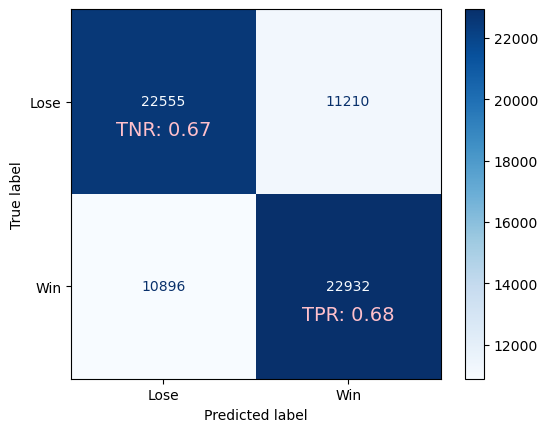

In [13]:
xgb_pred_label = [1 if val >= 0.5 else 0 for val in xgb_pred]
xgb_confusion = confusion_matrix(y_test,xgb_pred_label)
print(xgb_confusion)
# Calculate true positive rate (sensitivity)
TPR = xgb_confusion[1, 1] / (xgb_confusion[1, 1] + xgb_confusion[1, 0])
TNR = xgb_confusion[0, 0] / (xgb_confusion[0, 0] + xgb_confusion[0, 1])
Accuracy = (xgb_confusion[1, 1] +xgb_confusion[0, 0]) /(xgb_confusion[0, 0] + xgb_confusion[1, 0]+xgb_confusion[0, 1] + xgb_confusion[1, 1])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_confusion, display_labels=['Lose', 'Win'])
disp.plot(cmap='Blues', values_format='d')  # Adjust the colormap and format as needed

# Add text for TPR and TNR
plt.text(1, 1.1, f'TPR: {TPR:.2f}', color='pink', fontsize=14, va='top', ha='center')
plt.text(0, 0.1, f'TNR: {TNR:.2f}', color='pink', fontsize=14, va='top', ha='center')

# Show the plot
plt.show()

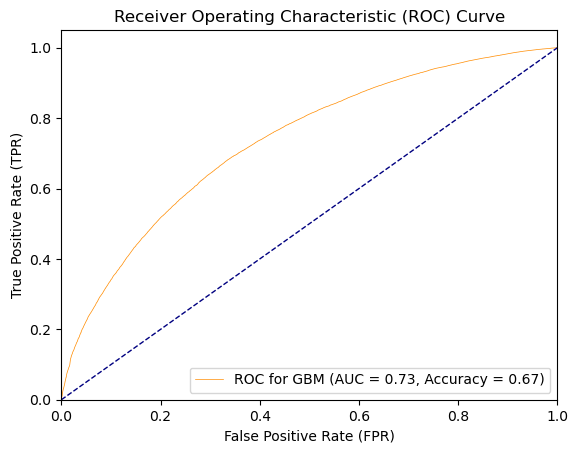

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import mean_squared_error
fpr1, tpr1, thresholds = roc_curve(y_test, xgb_pred)
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, color='darkorange', lw=.5, label=f'ROC for GBM (AUC = {roc_auc1:.2f}, Accuracy = {Accuracy:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Neural networks

# Is difference in ranking a sufficient predictor?

In [15]:
from sklearn.metrics import accuracy_score
import xgboost as xgb

def model_complex(num_vars, cat_vars):
  preprocessor = ColumnTransformer([
    ('numeric', numeric_pipe, num_vars),
    ('categorical', cat_pipe, cat_vars)
  ], remainder="drop")

  xgb_clf = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", xgb.XGBClassifier())
  ])
  xgb_clf.fit(X_train, y_train)
  y_pred = xgb_clf.predict(X_test)
  #return y_pred
  accuracy = round(accuracy_score(y_test, y_pred),3)
  print("Accuracy:", accuracy)




In [16]:

a0 = model_complex(num_vars=["rank_diff"],cat_vars=[]) # only rank_diff
a1 = model_complex(num_vars=num_var,cat_vars=cat_var) # rank_diff + all other variabbles
print(a0,a1)


Accuracy: 0.636
Accuracy: 0.673
None None


We see that there is a slight increase in the accuracy score, when considering all variables against a model with only the difference in rating, suggesting the other variables contribute to a greater prediction accuracy.

# Hyper-parameter tuning

In [17]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
import xgboost as xgb 

In [18]:
%%script false
param_dist = {
    'regressor__max_depth': stats.randint(3, 10),
    'regressor__learning_rate': stats.uniform(0.01, 0.1),
    'regressor__subsample': stats.uniform(0.5, 1),
    'regressor__n_estimators':stats.randint(100, 600)
}

xgb_model  = Pipeline(
    [
        ("preprocessor",preprocessor1),
        ("regressor", xgb.XGBClassifier())
    ]
)

# Create the RandomizedSearchCV object
best_fit_GBM = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=4, cv=3, scoring='accuracy')

# Fit the RandomizedSearchCV object to the training data
best_fit_GBM.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", best_fit_GBM .best_params_)
print("Best score: ", best_fit_GBM .best_score_)


Couldn't find program: 'false'


## Saving tuned model using pickle

In [19]:
%%script false
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "XGBoost_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(best_fit_GBM , file)

Couldn't find program: 'false'


### Accuracy of the tuned model on safer side predictions

In [20]:
%%script false
loaded_model = pickle.load(open("XGBoost_model.pkl"  , 'rb'))

import numpy as np
y_test = np.array(y_test).reshape(-1)
xgb_pred = loaded_model.predict_proba(X_test)[:,1]

data = pd.DataFrame({'y_test': y_test, 'xgb_pred' : xgb_pred.flatten() })
data = data[(data['xgb_pred'] > 0.5)]
data['xgb_pred_cat'] = data['xgb_pred'].apply(lambda x: 1 if x >= 0.5 else 0)

from sklearn.metrics import accuracy_score

## Calculate accuracy
mis = round(1 - accuracy_score(data['y_test'], data['xgb_pred_cat']),2)

print(f"Misclassification rate for safe-side predictions: {mis:.2f}")

Couldn't find program: 'false'


### Calibration plot for tuned model

In [21]:
%%script false
from sklearn.calibration import calibration_curve
xgb_pred = best_fit_GBM.predict_proba(X_test)[:,1]
res = calibration_curve(y_test, xgb_pred, n_bins=15)
plt.plot(res[0], res[1], marker='o', label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean observed probability')
plt.ylabel('Mean predicted probability')
plt.legend()

Couldn't find program: 'false'


# Bootstrapping models

In [22]:
%%script false
params = {k.replace("regressor__", ""): round(v,2) for k, v in loaded_model.best_params_.items()}
print(params)

Couldn't find program: 'false'


In [23]:

%%script false
bootstrap_models = []
from tqdm import tqdm
# Number of bootstrap repetitions
B = 0

# Bootstrap sampling and model fitting
for i in tqdm(range(B)):
 bootstrap_indices = np.random.choice(X_train.index, size=len(X_train), replace=True)
 X_boot = X_train.loc[bootstrap_indices]
 y_boot = y_train.loc[bootstrap_indices]
 
 xgb_model  = Pipeline(
  
    [
        ("preprocessor",preprocessor1),
        ("regressor", 
         xgb.XGBClassifier(
         #**params
         ))
    ]
)
 
 model = xgb_model.fit(X_boot, y_boot)
 bootstrap_models.append(model)

Couldn't find program: 'false'


Due to the large running time, we fit on the default gradient boosting model. This model has an accuracy similar to the best fit XGBoost.

In [24]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "default_gb_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(xgb_clf , file)

In [25]:
bootstrap_models = []
from tqdm import tqdm
# Number of bootstrap repetitions
B = 5

# Bootstrap sampling and model fitting
for i in tqdm(range(B)):
 bootstrap_indices = np.random.choice(X_train.index, size=len(X_train), replace=True)
 X_boot = X_train.loc[bootstrap_indices]
 y_boot = y_train.loc[bootstrap_indices]
 
 gb_model  = Pipeline(
  
    [
        ("preprocessor",preprocessor1),
        ("regressor", 
        xgb.XGBClassifier())
    ]
)
 
 model = gb_model.fit(X_boot, y_boot)
 bootstrap_models.append(model)

100%|██████████| 5/5 [01:15<00:00, 15.08s/it]


In [26]:
excluded_indices = []
for i in range(len(bootstrap_models)):
    try:
        bootstrap_models[i].predict_proba(X_train)[:,1]
    except ValueError:
        excluded_indices.append(i)

bootstrap_models = [bootstrap_models[i] for i in range(len(bootstrap_models)) if i not in excluded_indices]


### Saving bootstrapped models

In [27]:
import pickle

model_pkl_file = "bootstrap_models.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(bootstrap_models , file)